In [1]:
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 50  #  75 W- 100W 48.75-50.00 dBm
jam_power_dbm = 70
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
Jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)

N0 = noise_power_watt

T_sys = 300.0  # K  realistic mid-value for LEO sat RX
N0 = 1.38e-23 * 100e6 * T_sys*La_linear
P0 = Tx_power_watt
P1 = Jam_power_watt


In [2]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from minmax_solvers import (
    solve_game_bestresp_Q0_then_Q1,
    compute_J
)
from CloseBF import jammeraware_Q
from Dishjammersolver import optimal_Q0
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray
from numpy.linalg import cholesky, solve, eigh


# Generate RX positions
jam_dist = 1
# distances_km = [5,15,10,20]
# distances_km = [jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist]
# distances_km = [jam_dist,jam_dist,jam_dist,jam_dist]
distances_km = [jam_dist]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")


# Compute SAT intersection points

# sat_orbit_m = 500e3
# # angles = [(1, 90-(1e-9))]
# # angles = [(45, 50-(1e-3)), (120, 47), (180,80), (165, 72),(230,50)]
# # angles = [(50, 70-(1e-3)), (130,70)]
# angles = [(117.88, 56.2),(230.22, 72.96), (198,60.5),(345.49,65.65), (272.81, 60.03)]
# # angles = [(117.88, 56.2),(230.22, 72.96), (198,60.5),(305.49,65.65), (272.81, 60.03)]
# # angles = [(117.88, 66.2),(200.22, 62.96), (248,57.5),(355.49,57.65), (20.81, 57.03)]
# sat_positions = []
# delays_ms = []
# fspl_db = []
# frequency_hz = 10e9 
# wavelength = 3e8 / frequency_hz

# for az, el in angles:
#     pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
#     sat_positions.append(pos)
#     delays_ms.append(delay)
#     fspl = 20 * np.log10(4 * np.pi * dist / wavelength)
#     fspl_db.append(fspl)

# sat_positions = np.array(sat_positions)
# delays_ms = np.array(delays_ms)
# fspl_db = np.array(fspl_db)

# print("\nSatellite Pos [m]:\n", sat_positions)
# # print("\nPropagation delays [ms]:\n", delays_ms)
# # print("\nFree-space path loss [dB]:\n", fspl_db)


# # Compute az/el/dist per TX-SAT
  
# for i, tx in enumerate(gnd_positions):
#     print(f"\nFrom TX{i}:")
#     for j, sat in enumerate(sat_positions):
#         az, el, dist, n_waves = compute_az_el_dist(sat, tx, frequency_hz)
#         print(f"  SAT{j}: az={az:.2f}°, el={el:.2f}°, dist={dist:.2f} m, λ count ≈ {n_waves:.2f}")


TX0(m): [0. 0. 0.]
TX1(m): [ 6.12323397e-14  9.99999996e+02 -7.84806153e-02]


jitc_llvm_init(): LLVM API initialization failed ..


In [25]:
# %%
import json
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

def best_time_for_k(jsonl_path: str | Path, m: int, n: int = 1, distinct: bool = True):
    """
    Find the times corresponding to the n-th largest J_last for k = m.

    Args:
        jsonl_path: path to JSONL file.
        m:         target k value.
        n:         rank to select (1 = largest).
        distinct:  if True, rank by distinct value levels (recommended).
                   if False, rank by entry order after sorting (allows duplicates to occupy multiple ranks).

    Returns:
        (selected_times, selected_value, ranking_basis)
        - selected_times: list of times tied at the selected value
        - selected_value: the numeric J_last value at rank n
        - ranking_basis:  sorted list used for ranking (distinct or full list)
    """
    jsonl_path = Path(jsonl_path)

    vals, times = [], []
    with jsonl_path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)
            if int(obj.get("k", -1)) != int(m):
                continue
            J_series = obj.get("hist", {}).get("J", [])
            if not J_series:
                continue
            last_val = float(np.real(J_series[-1]))
            vals.append(last_val)
            times.append(obj.get("time"))

    if not vals:
        print(f"[Info] No entries found for k={m}.")
        return [], None, []

    # Build the ranking basis
    if distinct:
        basis = sorted(set(vals), reverse=True)
    else:
        basis = sorted(vals, reverse=True)

    if n < 1 or n > len(basis):
        print(f"[Info] Rank n={n} is out of range (available ranks: 1..{len(basis)}).")
        return [], None, basis

    target_value = basis[n-1]
    # All times tied at that value
    selected_times = [t for v, t in zip(vals, times) if v == target_value]

    print(f"✅ k={m}, rank n={n} ({'distinct' if distinct else 'non-distinct'})")
    print(f"   Selected J_last value: {target_value}")
    print(f"   Matching times: {selected_times}")

    return selected_times, target_value, basis

# ---- You already have ----
# selected_times, target_value, _ = best_time_for_k("allarray7km.jsonl", m=5, n=2, distinct=True)
csv_path = Path("starlink_randtimepoint_400.csv")  # adjust path if needed
frequency_hz = 10e9
c = 3e8
wavelength = c / frequency_hz

# ---- Helper ----
def top5_sats_for_time(df: pd.DataFrame, time_str: str):
    # Parse times to pandas datetime for robust comparison
    df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
    time_query = pd.to_datetime(time_str, errors="coerce")

    # Filter for exact same time (within 1 second tolerance just in case)
    tdf = df[np.abs((df["Time"] - time_query).dt.total_seconds()) < 1.0].copy()
    if tdf.empty:
        print(f"[WARN] No rows found for Time ≈ '{time_str}'")
        return None

    # Sort by Slant km (ascending = nearer) and take top 5
    tdf = tdf.sort_values("Slant km", ascending=True).head(5).reset_index(drop=True)

    positions = [
        np.array([row["x_East (m)"], row["y_North (m)"], row["z_Up (m)"]], dtype=float)
        for _, row in tdf.iterrows()
    ]
    azel = list(zip(tdf["Azimuth (°)"].astype(float), tdf["Elevation (°)"].astype(float)))
    names = tdf["Name"].astype(str).tolist()
    dist_m = (tdf["Slant km"].astype(float).to_numpy() * 1000.0)
    delays_ms = (dist_m / c) * 1e3
    fspl_db = 20.0 * np.log10(4.0 * np.pi * dist_m / wavelength)

    return {
        "time": str(time_query),
        "names": names,
        "positions": positions,
        "az_el_deg": azel,
        "dist_m": dist_m,
        "delays_ms": delays_ms,
        "fspl_db": fspl_db,
        "table": tdf,
    }


In [26]:

# ---- Load once ----
df = pd.read_csv(csv_path)

selected_times, target_value,_ = best_time_for_k("allarray1km.jsonl", m=5, n=6, distinct=True) 
if not selected_times:
    raise ValueError("selected_times is empty. Run best_time_for_k() first.")
time_use = selected_times[0]

res = top5_sats_for_time(df, time_use)
if res is None:
    raise ValueError(f"No satellites found for time={time_use}")

# ---- Replace your sat_positions / delays / etc ----
sat_positions = res["positions"]
delays_ms     = res["delays_ms"].tolist()
fspl_db       = res["fspl_db"].tolist()
sat_names     = res["names"]
sat_az_el     = res["az_el_deg"]

print(f"Time used: {res['time']}")
print("Top-5 satellites (nearest by Slant km):")
for i, (nm, pos, (az, el), d_km) in enumerate(zip(
        sat_names, sat_positions, sat_az_el, res["dist_m"]/1000.0)):
    print(f"  #{i+1}: {nm:>12s} | Slant={d_km:8.2f} km | az={az:7.2f}°, el={el:6.2f}° | "
          f"x={pos[0]:.1f} m, y={pos[1]:.1f} m, z={pos[2]:.1f} m")
for i, tx in enumerate(gnd_positions):
    print(f"\nFrom TX{i}:")
    for j, sat in enumerate(sat_positions):
        az, el, dist, n_waves = compute_az_el_dist(sat, tx, frequency_hz)
        print(f"  SAT{j}: az={az:.2f}°, el={el:.2f}°, dist={dist:.2f} m, λ count ≈ {n_waves:.2f}")

✅ k=5, rank n=6 (distinct)
   Selected J_last value: 1.4000653768889133
   Matching times: ['2025-10-29T17:18:56']
Time used: 2025-10-29 17:18:56
Top-5 satellites (nearest by Slant km):
  #1: STARLINK-11501 [DTC] | Slant=  450.50 km | az= 271.16°, el= 51.12° | x=-282733.4 m, y=5714.9 m, z=350727.0 m
  #2: STARLINK-11271 [DTC] | Slant=  450.80 km | az=  20.94°, el= 52.17° | x=98830.2 m, y=258202.3 m, z=356009.9 m
  #3: STARLINK-32334 | Slant=  532.20 km | az=  41.38°, el= 62.49° | x=162461.6 m, y=184433.4 m, z=472020.0 m
  #4: STARLINK-31134 | Slant=  551.20 km | az=  41.63°, el= 60.51° | x=180233.3 m, y=202799.7 m, z=479778.3 m
  #5: STARLINK-1017 | Slant=  557.20 km | az= 297.52°, el= 69.14° | x=-176000.6 m, y=91689.5 m, z=520689.3 m

From TX0:
  SAT0: az=178.84°, el=51.12°, dist=450533.31 m, λ count ≈ 15017777.02
  SAT1: az=69.06°, el=52.17°, dist=450753.69 m, λ count ≈ 15025122.85
  SAT2: az=48.62°, el=62.49°, dist=532176.97 m, λ count ≈ 17739232.44
  SAT3: az=48.37°, el=60.51°, dis

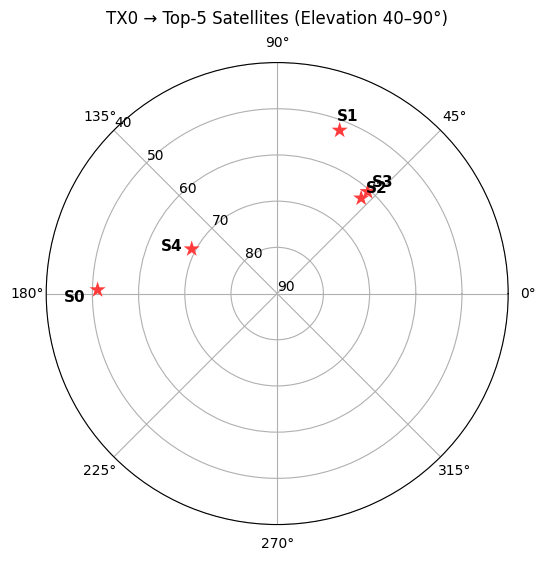

In [27]:
# ==== 自动绘制 From TX0 的五颗卫星在极坐标图上 (E→CCW) ====
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def compute_az_el_dist_math(sat_pos, gnd_pos, frequency_hz: float | None = None):
    """
    返回 az_eccw (E-CCW)、el_deg、dist 以及（可选）n_waves。
    注意：这与 compute_az_el_dist 的 North-CW 输出不同；这是给绘图/steering 用的。
    """
    vec  = sat_pos - gnd_pos
    dist = float(np.linalg.norm(vec))
    dx, dy, dz = vec / (dist + 1e-15)
    el_rad  = np.arcsin(dz)
    az_east = np.arctan2(dy, dx)                              # 0°=East, CCW
    az_eccw = (np.degrees(az_east) + 360.0) % 360.0
    el_deg  = float(np.degrees(el_rad))
    if frequency_hz is not None:
        wavelength = 3e8 / frequency_hz
        n_waves = dist / wavelength
        return az_eccw, el_deg, dist, n_waves
    return az_eccw, el_deg, dist


def make_sat_azel_for_tx_math(tx_pos, sat_positions, freq_hz):
    """为绘图/steering 构造卫星角度（E-CCW）。"""
    out = []
    for sat in sat_positions:
        az_eccw, el_deg, _, _ = compute_az_el_dist_math(sat, tx_pos, freq_hz)
        out.append((az_eccw, max(0.0, min(90.0, el_deg))))
    return out
# 自动计算 E-CCW 方位角和仰角
sat_az_el_tx0 = make_sat_azel_for_tx_math(gnd_positions[0], sat_positions, frequency_hz)
sat_az_el_tx0 = sat_az_el_tx0[:5]  # 只画前5颗
sat_names = [f"S{i}" for i in range(len(sat_az_el_tx0))]

# === 绘图 ===
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="polar")

# 极坐标配置（E→CCW；仰角40–90°）
ax.set_theta_zero_location("E")
ax.set_theta_direction(1)
ax.set_rlim(90, 40)
ax.set_rlabel_position(135)
ax.set_title("TX0 → Top-5 Satellites (Elevation 40–90°)", va="bottom", fontsize=12)

# 绘制红色无边五角星，并在外侧标注 S0–S4
for i, (az_deg, el_deg) in enumerate(sat_az_el_tx0):
    az_r = np.deg2rad(az_deg)
    ax.scatter(az_r, el_deg, s=150, marker="*", color="#FF3B3B", edgecolors="none", zorder=4)
    # 标签略远一些（减小重叠），白色字体
    ax.text(az_r, el_deg - 5.0, sat_names[i], ha="center", va="top",
            color="black", fontsize=11, zorder=5, weight="bold")

# 保存与展示
out_dir = Path("result_plot")
out_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(out_dir / "tx0_top5_satellites_polar.png", dpi=300, bbox_inches="tight")
fig.savefig(out_dir / "tx0_top5_satellites_polar.pdf", dpi=300, bbox_inches="tight")

plt.show()


In [4]:
from sionna.rt import Receiver, Transmitter, PlanarArray, PathSolver, load_scene
import numpy as np
import vsat_dish_3gpp


def compute_cir(tx_pos, rx_pos, tx_array, rx_array,tx_look_at, rx_look_at, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = load_scene()
    scene.frequency = frequency
    scene.synthetic_array = True
    
    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 

    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos, display_radius=200)
    scene.add(tx)
    
    earth_radius_m = 6371e3
    rx_look_at2 = np.array([0.0, 0.0, -1*earth_radius_m/2])
    
    if isinstance(tx_look_at, str) and tx_look_at.lower() in ["up-z", "up", "z"]:
        tx_look_at = np.array(tx_pos) + np.array([0.0, 0.0, 100000.0])
    tx.look_at(tx_look_at)
    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(rx_look_at2)
        rx_list.append(rx)
    tx.look_at( tx_look_at)

    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                #    seed=41
                   )

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")

    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
    
    return a_all, tau_all

jam_rows =6
jam_cols = 6
jam_antennas = jam_cols*jam_rows

sat_rows = 6
sat_cols = 6
sat_antennas = sat_cols*sat_rows

tx_rows = 6
tx_cols = 6
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")
                        # pattern="iso", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                            # pattern="vsat_dish",
                            pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                             pattern="tr38901",
                            #  pattern="iso",
                             polarization="V")

def collapse_channel(a_cir, t_idx=0):
    """
    Collapse channel tensor at a given time index.
    Input:
      a_cir: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    Output:
      H_t: (M, N), M = num_rx*num_rx_ant, N = num_tx*num_tx_ant
    """
    nr, nra, nt, nta, npaths, ntimes = a_cir.shape
    assert 0 <= t_idx < ntimes
    H_t = a_cir[..., t_idx]             # select time slice
    H_t = H_t.sum(axis=-1)              # sum over paths
    H_t = H_t.reshape(nr*nra, nt*nta)   # merge Rx/Tx antennas
    return H_t


In [5]:
# a_tx,  tau_tx  = compute_cir(gnd_positions[0], sat_positions, tx_array,  sat_array,
#                                 np.array(gnd_positions[0]) + np.array([0.0, 0.0, 100.0]), gnd_positions[0])


# # a_tx,  tau_tx  = compute_cir(gnd_positions[0], sat_positions, tx_array,  sat_array,
# #                                 sat_positions[0], gnd_positions[0])


# a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, jam_array,  sat_array,
#                                 sat_positions[0], gnd_positions[0])


# H0_full = collapse_channel(a_tx)   # shape: (K*Nr, Nt0)
# H1_full = collapse_channel(a_jam)  # shape: (K*Nr, Nt1)

# k_sel = 3
# H_tx = H0_full[:k_sel*sat_antennas, :]
# H_jam = H1_full[:k_sel*sat_antennas, :]

# n1 = H_jam .shape[1]
# Q1_init = (P1/n1) * np.eye(n1, dtype=complex)

# Q0, Q1, n_it, hist = solve_game_bestresp_Q0_then_Q1(
#             H_tx, H_jam , N0,
#             P0=P0, P1=P1,
#             max_outer=400, tol=1e-6, inner_Q1_steps=2,
#             geometry='entropy',        # 'euclidean' → Extragradient; 'entropy' → Mirror-Prox
#             step_rule='adp',           # 'fixed' → fixed step size; 'adp' → adaptive step size
#             eta=0.8,                   # used only when step_rule='fixed'
#             eta_init=1,              # initial step size for adaptive mode
#             eta_min=1.5e-1, eta_max=100.0, # range of step size for adaptive mode
#             beta=0.1, gamma=1.01,      # backtracking shrink/expand factors
#             multi_stream=True,         # multi-stream water-filling for Q0
#             verbose=True,              # print progress
#             track_hist=True,           # record history curves
#             Q1_init=Q1_init
#             )
# # print("Capacity [bit/s/Hz] =",  hist[-1])
# print(np.linalg.matrix_rank(Q0))
# print(np.linalg.matrix_rank(Q1))

In [6]:
# =========================
# 1) 角度/坐标工具（E-CCW）
# =========================
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv as Jv

def _azel_to_unitvec_eccw(az_deg: float, el_deg: float):
    """E-CCW: 0°=East, CCW positive → unit vector (x=E, y=N, z=U)."""
    az = np.deg2rad(az_deg); el = np.deg2rad(el_deg)
    return np.array([np.cos(el)*np.cos(az), np.cos(el)*np.sin(az), np.sin(el)], dtype=float)

def compute_az_el_dist_math(sat_pos, gnd_pos, frequency_hz: float | None = None):
    """
    返回 az_eccw (E-CCW)、el_deg、dist 以及（可选）n_waves。
    注意：这与 compute_az_el_dist 的 North-CW 输出不同；这是给绘图/steering 用的。
    """
    vec  = sat_pos - gnd_pos
    dist = float(np.linalg.norm(vec))
    dx, dy, dz = vec / (dist + 1e-15)
    el_rad  = np.arcsin(dz)
    az_east = np.arctan2(dy, dx)                              # 0°=East, CCW
    az_eccw = (np.degrees(az_east) + 360.0) % 360.0
    el_deg  = float(np.degrees(el_rad))
    if frequency_hz is not None:
        wavelength = 3e8 / frequency_hz
        n_waves = dist / wavelength
        return az_eccw, el_deg, dist, n_waves
    return az_eccw, el_deg, dist

def make_sat_azel_for_tx_math(tx_pos, sat_positions, freq_hz):
    """为绘图/steering 构造卫星角度（E-CCW）。"""
    out = []
    for sat in sat_positions:
        az_eccw, el_deg, _, _ = compute_az_el_dist_math(sat, tx_pos, freq_hz)
        out.append((az_eccw, max(0.0, min(90.0, el_deg))))
    return out

# =========================
# 2) 元件方向图（以 E-CCW 入参）
# =========================
def tr38901_elem_gain_db_centered(az_deg, el_deg, az0_deg, el0_deg,
                                  Gmax=8.0, phi_3dB=65.0, theta_3dB=65.0,
                                  Am=30.0, SLA_v=30.0):
    """
    TR 38.901 单元方向图（与 Sionna v_tr38901_pattern 一致的简化版）。
    所有角度均为 E-CCW；boresight=(az0_deg, el0_deg) 亦为 E-CCW。
    """
    # 建立以 boresight 为 x' 轴的局部基
    x0 = _azel_to_unitvec_eccw(az0_deg, el0_deg)
    x0 = x0 / (np.linalg.norm(x0) + 1e-15)
    up = np.array([0.0, 0.0, 1.0])
    z0 = up - np.dot(up, x0) * x0
    if np.linalg.norm(z0) < 1e-12:
        alt = np.array([1.0, 0.0, 0.0])
        if abs(np.dot(alt, x0)) > 0.9:
            alt = np.array([0.0, 1.0, 0.0])
        z0 = alt - np.dot(alt, x0) * x0
    z0 = z0 / (np.linalg.norm(z0) + 1e-15)
    y0 = np.cross(z0, x0); y0 = y0 / (np.linalg.norm(y0) + 1e-15)
    R  = np.stack([x0, y0, z0], axis=1)  # 列为局部基

    v_g = _azel_to_unitvec_eccw(az_deg, el_deg)
    v_l = R.T @ v_g  # global→local
    zc  = np.clip(v_l[2], -1.0, 1.0)
    theta = np.arccos(zc)                    # 与 boresight 垂直面的偏离角
    phi   = np.arctan2(v_l[1], v_l[0])       # 方位角（局部）
    theta_deg = np.degrees(theta); phi_deg = np.degrees(phi)

    A_v = -min(12.0*((theta_deg-90.0)/theta_3dB)**2, SLA_v)
    A_h = -min(12.0*((phi_deg)/phi_3dB)**2, Am)
    A   = -min(-(A_v + A_h), Am)
    return float(Gmax + A)


# =========================
# 3) 阵列响应与功率图（E-CCW）
# =========================
def planar_steering_vector(n_rows, n_cols, dx_lambda, dy_lambda, az_deg, el_deg, elem_gain_fn=None):
    k  = 2.0*np.pi
    az = np.deg2rad(az_deg); el = np.deg2rad(el_deg)
    ux = np.cos(el)*np.cos(az); uy = np.cos(el)*np.sin(az)
    c_idx = np.arange(n_cols); r_idx = np.arange(n_rows)
    # phase_x = np.exp(1j*k*dx_lambda*ux*c_idx)
    # phase_y = np.exp(1j*k*dy_lambda*uy*r_idx)
    phase_x = np.exp(-1j*k*dx_lambda*ux*c_idx)
    phase_y = np.exp(-1j*k*dy_lambda*uy*r_idx)
    a = np.kron(phase_y, phase_x).reshape((-1,1))
    if elem_gain_fn is not None:
        g_db = elem_gain_fn(az_deg, el_deg)
        a *= np.sqrt(10.0**(g_db/10.0))  # 场幅乘 √增益
    return a

def spatial_power_map(Q, n_rows, n_cols, az_grid, el_grid, elem_gain_fn=None, dx_lambda=0.5, dy_lambda=0.5):
    N = n_rows*n_cols
    if Q.shape != (N, N):
        raise ValueError(f"Q shape {Q.shape} != ({N},{N}) for {n_rows}x{n_cols}")
    P = np.zeros((len(el_grid), len(az_grid)), dtype=float)
    for i, el in enumerate(el_grid):
        for j, az in enumerate(az_grid):
            a = planar_steering_vector(n_rows, n_cols, dx_lambda, dy_lambda, az, el, elem_gain_fn)
            P[i, j] = float(np.real(a.conj().T @ Q @ a))
    P = np.maximum(P, 1e-16)
    P_db = 10.0*np.log10(P); P_db -= P_db.max()  # 归一到 0 dB 峰值
    return P_db

# =========================
# 4) 绘图（cartesian & polar），轴设为 E-CCW
# =========================
def plot_side_by_side_cartesian(P0_db, P1_db, az_grid, el_grid,
                                sat_tx=None, sat_jam=None,
                                title_left="TX beampattern", title_right="Jammer beampattern",
                                share_limits=False):
    if share_limits:
        vmin = min(P0_db.min(), P1_db.min()); vmax = 0.0
        vlims = [(vmin, vmax), (vmin, vmax)]
    else:
        vlims = [(P0_db.min(), 0.0), (P1_db.min(), 0.0)]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    # 左：TX
    ax = axes[0]
    im0 = ax.imshow(P0_db, origin="lower",
                    extent=[az_grid[0], az_grid[-1], el_grid[0], el_grid[-1]],
                    aspect="auto", vmin=vlims[0][0], vmax=vlims[0][1], cmap="viridis")
    ax.set_xlabel("Azimuth (deg, E→CCW)"); ax.set_ylabel("Elevation (deg)")
    ax.set_title(title_left)
    if sat_tx:
        azs = [a for a,_ in sat_tx]; els = [e for _,e in sat_tx]
        ax.scatter(azs, els, s=40, edgecolor="white", facecolor="none", linewidths=1.2)
        for k,(az,el) in enumerate(sat_tx):
            ax.text(az, el+1.5, f"S{k}", color="white", ha="center", va="bottom", fontsize=8)
    cbar0 = fig.colorbar(im0, ax=ax, shrink=0.9, pad=0.02)
    cbar0.set_label("Normalized gain (dB)")

    # 右：Jammer
    ax = axes[1]
    im1 = ax.imshow(P1_db, origin="lower",
                    extent=[az_grid[0], az_grid[-1], el_grid[0], el_grid[-1]],
                    aspect="auto", vmin=vlims[1][0], vmax=vlims[1][1], cmap="viridis")
    ax.set_xlabel("Azimuth (deg, E→CCW)"); ax.set_ylabel("Elevation (deg)")
    ax.set_title(title_right)
    if sat_jam:
        azs = [a for a,_ in sat_jam]; els = [e for _,e in sat_jam]
        ax.scatter(azs, els, s=40, edgecolor="white", facecolor="none", linewidths=1.2)
        for k,(az,el) in enumerate(sat_jam):
            ax.text(az, el+1.5, f"S{k}", color="white", ha="center", va="bottom", fontsize=8)
    cbar1 = fig.colorbar(im1, ax=ax, shrink=0.9, pad=0.02)
    cbar1.set_label("Normalized gain (dB)")

    plt.show()

def plot_side_by_side_polar(P0_db, P1_db, az_grid, el_grid,
                            sat_tx=None, sat_jam=None,
                            title_left="TX beampattern (Polar)", title_right="Jammer beampattern (Polar)",
                            share_limits=False):
    # 轴按 E-CCW：theta=0 在 East，方向 CCW
    az_r = np.deg2rad(az_grid); El = np.array(el_grid)
    Az, Elm = np.meshgrid(az_r, El)

    if share_limits:
        vmin = min(P0_db.min(), P1_db.min()); vmax = 0.0
        vlims = [(vmin, vmax), (vmin, vmax)]
    else:
        vlims = [(P0_db.min(), 0.0), (P1_db.min(), 0.0)]

    fig = plt.figure(figsize=(12, 6), constrained_layout=True)
    ax0 = fig.add_subplot(1, 2, 1, projection="polar")
    ax1 = fig.add_subplot(1, 2, 2, projection="polar")

    # 左：TX
    ax = ax0
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_rlim(90, 45)
    ax.set_rlabel_position(135)
    ax.set_title(title_left, va="bottom", fontsize=12)
    im0 = ax.pcolormesh(Az, Elm, P0_db, shading="auto", cmap="viridis",
                        vmin=vlims[0][0], vmax=vlims[0][1])
    if sat_tx:
        for k,(az,el) in enumerate(sat_tx):
            ax.plot(np.deg2rad(az), el, 'wo', markersize=5, markeredgewidth=1.2)
            ax.text(np.deg2rad(az), el-2, f"S{k}", color='w', ha='center', va='top', fontsize=8)
    cbar0 = fig.colorbar(im0, ax=ax, shrink=0.9, pad=0.02)
    cbar0.set_label("Normalized gain (dB)")

    # 右：Jammer
    ax = ax1
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_rlim(90, 45)
    ax.set_rlabel_position(135)
    ax.set_title(title_right, va="bottom", fontsize=12)
    im1 = ax.pcolormesh(Az, Elm, P1_db, shading="auto", cmap="viridis",
                        vmin=vlims[1][0], vmax=vlims[1][1])
    if sat_jam:
        for k,(az,el) in enumerate(sat_jam):
            ax.plot(np.deg2rad(az), el, 'wo', markersize=5, markeredgewidth=1.2)
            ax.text(np.deg2rad(az), el-2, f"S{k}", color='w', ha='center', va='top', fontsize=8)
    cbar1 = fig.colorbar(im1, ax=ax, shrink=0.9, pad=0.02)
    cbar1.set_label("Normalized gain (dB)")

    plt.show()

# =========================
# 5) 主入口：几何联动 + 绘图
# =========================
def draw_tx_and_jam_radiomap(
    Q0, Q1,
    gnd_positions, sat_positions,
    tx_rows, tx_cols,
    jam_rows, jam_cols,
    frequency_hz=10e9,
    tx_Gmax=8.0,          # TX 元件最大增益 (dBi)
    jam_Gmax=8.0,         # Jammer 元件最大增益 (dBi)
    use_absolute_power=False,
    P0_watt=None, P1_watt=None
):
    """
    TX/Jammer 均采用 TR 38.901 元件方向图，且 boresight 固定为 z-up：(az=0°, el=90°)。
    卫星角仅用作图中标注，不再影响元素增益或阵列指向。
    """
    # 角度网格（E-CCW）
    az_grid = np.linspace(0, 360, 361)   # 0°=East, CCW
    el_grid = np.linspace(45, 90, 51)

    # 卫星相对地面位置 → 仅用于图中标注（不影响boresight）
    sat_azel_tx0 = make_sat_azel_for_tx_math(gnd_positions[0], sat_positions, frequency_hz)
    sat_azel_jam = make_sat_azel_for_tx_math(gnd_positions[1], sat_positions, frequency_hz)

    # 固定 boresight = z-up
    az0_tx,  el0_tx  = 0.0, 90.0
    az0_jm,  el0_jm  = 0.0, 90.0

    # 元件方向图（TR 38.901）——两者一致
    tx_elem_fn  = lambda az,el: tr38901_elem_gain_db_centered(
        az, el, az0_tx, el0_tx, Gmax=tx_Gmax, phi_3dB=65.0, theta_3dB=65.0, Am=30.0, SLA_v=30.0
    )
    jam_elem_fn = lambda az,el: tr38901_elem_gain_db_centered(
        az, el, az0_jm, el0_jm, Gmax=jam_Gmax, phi_3dB=65.0, theta_3dB=65.0, Am=30.0, SLA_v=30.0
    )

    # 阵列空间功率（相对峰值，dB）
    P0_db = spatial_power_map(Q0, tx_rows, tx_cols, az_grid, el_grid, tx_elem_fn)
    P1_db = spatial_power_map(Q1, jam_rows, jam_cols, az_grid, el_grid, jam_elem_fn)

    # 可选：叠加绝对功率（若提供发射功率）
    if use_absolute_power and (P0_watt is not None) and (P1_watt is not None):
        P0_db = P0_db + 10.0*np.log10(max(P0_watt, 1e-30))
        P1_db = P1_db + 10.0*np.log10(max(P1_watt, 1e-30))

    # 绘图（E-CCW 轴）
    plot_side_by_side_cartesian(
        P0_db, P1_db, az_grid, el_grid,
        sat_tx=sat_azel_tx0, sat_jam=sat_azel_jam,
        title_left="TX beampattern (TR 38.901, z-up)",
        title_right="Jammer beampattern (TR 38.901, z-up)",
        share_limits=False
    )

    plot_side_by_side_polar(
        P0_db, P1_db, az_grid, el_grid,
        sat_tx=sat_azel_tx0, sat_jam=sat_azel_jam,
        title_left="TX (Polar, TR 38.901, z-up)",
        title_right="Jammer (Polar, TR 38.901, z-up)",
        share_limits=False
    )


# =========================
# 6) （可选）一致性自检
# =========================
def sanity_check_angles(gnd0, sat_positions, freq_hz):
    sat_azel = make_sat_azel_for_tx_math(gnd0, sat_positions, freq_hz)
    for k, (az_eccw, el) in enumerate(sat_azel):
        v_plot = _azel_to_unitvec_eccw(az_eccw, el)
        v_geom = sat_positions[k] - gnd0
        v_geom = v_geom / (np.linalg.norm(v_geom) + 1e-15)
        err = np.degrees(np.arccos(np.clip(np.dot(v_plot, v_geom), -1, 1)))
        print(f"[sanity] S{k} angle error (deg): {err:.3e}")
# 假设你已有：
# Q0, Q1               # from optimal_Q0(...)
# gnd_positions        # 形如 [[0,0,0], jammer_offset, ...]（本地 ENU）
# sat_positions        # 由 compute_satellite_intersection_point_enu(...) 默认 tx_pos 生成的本地 ENU
# tx_rows, tx_cols
# jam_rows, jam_cols
# frequency_hz = 10e9
# P0_watt, P1_watt 可选

# sanity_check_angles(gnd_positions[0], sat_positions, frequency_hz)  # 可选，一次就能发现不一致


# draw_tx_and_jam_radiomap(
#     Q0, Q1,
#     gnd_positions, sat_positions,
#     tx_rows, tx_cols,
#     jam_rows, jam_cols,
#     frequency_hz=frequency_hz,
#     tx_Gmax=8.0,           # 如需不同，可调
#     jam_Gmax=8.0,          # 如需不同，可调
#     use_absolute_power=False,
#     P0_watt=None, P1_watt=None
#     # use_absolute_power=True,
#     # P0_watt=P0, P1_watt=P1
# )

/tmp/ipykernel_162394/1413424741.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[i, j] = float(np.real(a.conj().T @ Q @ a))


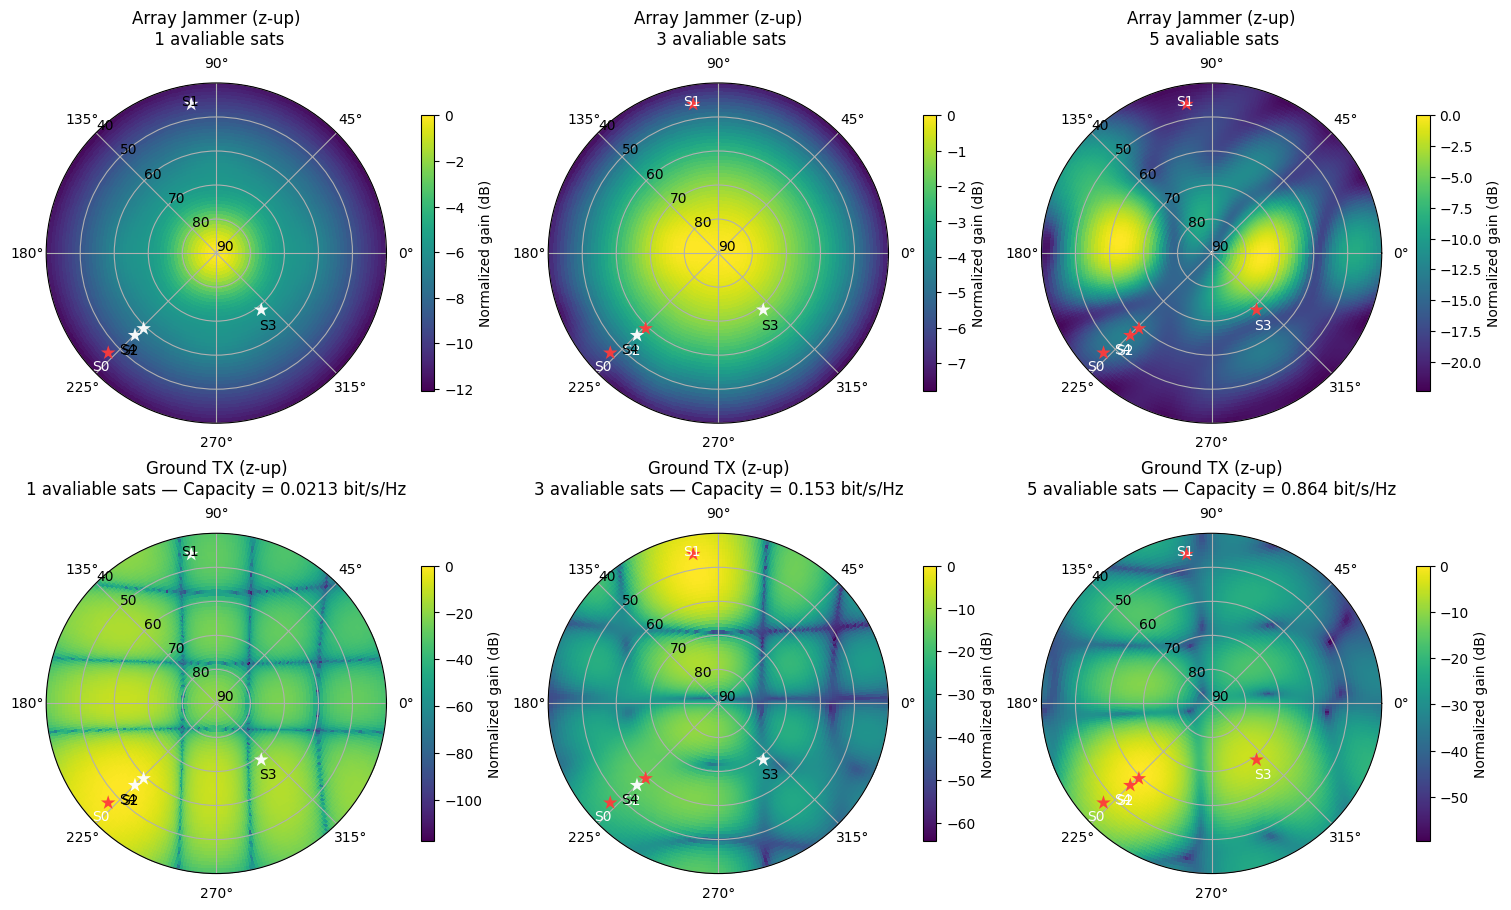

In [ ]:
# ==== 2×3 polar panel: Jammer(z-up, TR38901) + TX(z-up, TR38901) for k in (1,3,5) ====
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.patheffects as pe
from matplotlib import transforms as mtransforms

# ---------- sat markers: first k red stars, rest white stars ----------
def _draw_sat_points_k(ax, sat_list, k_highlight, *,
                       label_prefix="S",
                       star_size=120,
                       red_face="#FF3B3B",
                       white_face="#FFFFFF",
                       white_edge="none",        # ← 移除黑边
                       default_label_offset_deg=6.0,  # ← 让文字离得更远
                       label_offset_deg_map=None,
                       label_offset_px=10):      # ← 再多一点像素偏移
    """
    Plot satellites on polar map.
    - First k_highlight sats: red star (no edge, white label)
    - Others: white star (no edge, black label)
    """
    if not sat_list:
        return
    label_offset_deg_map = label_offset_deg_map or {}
    thetas = np.deg2rad([az for az,_ in sat_list])
    rs     = [el for _,el in sat_list]

    for idx, (theta, r) in enumerate(zip(thetas, rs)):
        if idx < k_highlight:
            face, edge, lw, tcolor = red_face, "none", 0.0, "#FFFFFF"
        else:
            face, edge, lw, tcolor = white_face, "none", 0.0, "#000000"

        ax.scatter([theta], [r], s=star_size, marker="*",
                   facecolors=face, edgecolors=edge, linewidths=lw,
                   zorder=5, alpha=0.95)

        extra = label_offset_deg_map.get(idx, 0.0)
        r_lab = r - (default_label_offset_deg + extra)
        ax.text(theta, r_lab, f"{label_prefix}{idx}",
                ha="center", va="top",
                fontsize=10, color=tcolor,
                zorder=6)


# ---------- tiny helpers ----------
def _sat_azels_for(tx_pos, sat_positions, freq_hz):
    return make_sat_azel_for_tx_math(tx_pos, sat_positions, freq_hz)  # list of (az_eccw, el_deg)

def _polar_panel(ax, P_db, az_grid, el_grid, *, title, cmap="viridis"):
    az_r = np.deg2rad(az_grid); El = np.array(el_grid)
    Az, Elm = np.meshgrid(az_r, El)
    ax.set_theta_zero_location("E")     # E-CCW frame
    ax.set_theta_direction(1)
    ax.set_rlim(90, 40)
    ax.set_rlabel_position(135)
    im = ax.pcolormesh(Az, Elm, P_db, shading="auto", cmap=cmap,
                       vmin=P_db.min(), vmax=0.0)
    ax.set_title(title, va="bottom", fontsize=12)
    return im

# ---------- main ----------
def draw_2x3_polar_panel_same_pattern(
    gnd_positions, sat_positions,
    tx_array, jam_array, sat_array,
    sat_antennas,            # per-satellite Rx elements (e.g., 6*6)
    tx_rows, tx_cols,
    jam_rows, jam_cols,
    frequency_hz=10e9,
    N0=1.0, P0=1.0, P1=1.0,
    ks=(1,3,5),
    Gmax_elem=8.0,           # TR38901 element Gmax (dBi), both TX & Jammer
    save_dir="result_plot", fname="radiomap_2x3_same_TR38901",
    cmap="viridis"
):
    """
    顶行: 每个 k 的 Jammer radiomap (Q1_k), 元素方向图 = TR38901(z-up)
    底行: 每个 k 的 TX     radiomap (Q0_k), 元素方向图 = TR38901(z-up)
    标注：每列前 k 颗卫星红星，其余白星
    """
    # Angle grids
    az_grid = np.linspace(0, 360, 361)
    el_grid = np.linspace(40, 90, 51)

    # Satellite markers (E-CCW)
    sat_tx_markers  = _sat_azels_for(gnd_positions[0], sat_positions, frequency_hz)
    sat_jam_markers = _sat_azels_for(gnd_positions[1], sat_positions, frequency_hz)

    # ---- TR38901 element pattern for BOTH TX and Jammer, z-up ----
    az0_upright, el0_upright = 0.0, 90.0
    tx_elem_fn  = lambda az,el: tr38901_elem_gain_db_centered(
        az, el, az0_upright, el0_upright, Gmax=Gmax_elem,
        phi_3dB=65.0, theta_3dB=65.0, Am=30.0, SLA_v=30.0
    )
    jam_elem_fn = lambda az,el: tr38901_elem_gain_db_centered(
        az, el, az0_upright, el0_upright, Gmax=Gmax_elem,
        phi_3dB=65.0, theta_3dB=65.0, Am=30.0, SLA_v=30.0
    )

    # ---- Compute CIR ONCE, then slice rows for each k ----
    a_tx,  tau_tx  = compute_cir(
        gnd_positions[0], sat_positions, tx_array,  sat_array,
        np.array(gnd_positions[0]) + np.array([0.0, 0.0, 100.0]), gnd_positions[0]
    )
    a_jam, tau_jam = compute_cir(
        gnd_positions[1], sat_positions, jam_array,  sat_array,
        sat_positions[0], gnd_positions[0]
    )
    H0_full = collapse_channel(a_tx)   # (K*Nr, Nt0)
    H1_full = collapse_channel(a_jam)  # (K*Nr, Nt1)

    results = []  # (k, Q0_k, Q1_k, C_k)
    for k_sel in ks:
        H_tx  = H0_full[:k_sel*sat_antennas, :]
        H_jam = H1_full[:k_sel*sat_antennas, :]

        # Use your solver (Mirror-Prox / adaptive)
        n1 = H_jam.shape[1]
        Q1_init = (P1/n1) * np.eye(n1, dtype=complex)
        Q0_k, Q1_k, _, _hist = solve_game_bestresp_Q0_then_Q1(
            H_tx, H_jam, N0,
            P0=P0, P1=P1,
            max_outer=400, tol=1e-6, inner_Q1_steps=2,
            geometry='entropy',
            step_rule='adp',
            eta=0.8,
            eta_init=1.0,
            eta_min=1.5e-1, eta_max=100.0,
            beta=0.1, gamma=1.01,
            multi_stream=True,
            verbose=False,
            track_hist=True,
            Q1_init=Q1_init
        )
        # Capacity = last J(Q0,Q1) in hist if你记录了；若没有返回，下面给个兼容：
        try:
            C_k = float(_hist['J'][-1])
        except Exception:
            # 若你的 solver 没直接返回 capacity，可自行替换为你的 capacity 计算
            C_k = np.nan
        results.append((k_sel, Q0_k, Q1_k, C_k))

    # ---- Plot 2×3 polar subplots ----
    fig = plt.figure(figsize=(15, 9), constrained_layout=True)
    gs  = fig.add_gridspec(2, 3)
    axes_top  = [fig.add_subplot(gs[0, i], projection="polar") for i in range(3)]
    axes_bot  = [fig.add_subplot(gs[1, i], projection="polar") for i in range(3)]

    # push S2 label a bit outward to avoid overlap
    label_offset_deg_map = {2: 3.0}

    # Top row: Jammer (Q1_k)
    for ax, (k_sel, _, Q1_k, _) in zip(axes_top, results):
        P1_db = spatial_power_map(Q1_k, jam_rows, jam_cols, az_grid, el_grid, jam_elem_fn)
        im = _polar_panel(ax, P1_db, az_grid, el_grid,
                          title=f"Array Jammer (z-up)\n {k_sel} avaliable sats",
                          cmap=cmap)
        _draw_sat_points_k(ax, sat_jam_markers, k_sel,
                           default_label_offset_deg=3.0,
                           label_offset_deg_map=label_offset_deg_map)
        cb = fig.colorbar(im, ax=ax, shrink=0.75, pad=0.02)
        cb.set_label("Normalized gain (dB)")

    # Bottom row: TX (Q0_k)
    for ax, (k_sel, Q0_k, _, C_k) in zip(axes_bot, results):
        P0_db = spatial_power_map(Q0_k, tx_rows, tx_cols, az_grid, el_grid, tx_elem_fn)
        title = f"Ground TX (z-up)\n{k_sel} avaliable sats — Capacity = {C_k:.3g} bit/s/Hz"
        im = _polar_panel(ax, P0_db, az_grid, el_grid, title=title, cmap=cmap)
        _draw_sat_points_k(ax, sat_tx_markers, k_sel,
                           default_label_offset_deg=3.0,
                           label_offset_deg_map=label_offset_deg_map)
        cb = fig.colorbar(im, ax=ax, shrink=0.75, pad=0.02)
        cb.set_label("Normalized gain (dB)")

    out_dir = Path(save_dir); out_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_dir / f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(out_dir / f"{fname}.pdf", dpi=300, bbox_inches="tight")
    plt.show()


# ===== Run =====
draw_2x3_polar_panel_same_pattern(
    gnd_positions=gnd_positions,
    sat_positions=sat_positions,
    tx_array=tx_array,
    jam_array=jam_array,
    sat_array=sat_array,
    sat_antennas=sat_antennas,           # e.g., 6*6
    tx_rows=tx_rows, tx_cols=tx_cols,    # e.g., 8, 8
    jam_rows=jam_rows, jam_cols=jam_cols,# e.g., 1, 1 (or your jammer panel size)
    frequency_hz=frequency_hz,
    N0=N0, P0=P0, P1=P1,
    ks=(1,3,5),
    Gmax_elem=8.0,                       # TX & Jammer share the same TR38901 element Gmax
    save_dir="result_plot",
    fname="radiomap_2x3_same_TR38901",
    cmap="viridis"                       # 你也可以换 "plasma"/"inferno" 等
)
